In [37]:
# Molecular weights of compounds under investigation
# BPA: 			228.29
# BPAG:			404.4
# (BPA-BPAG):	404.4 – 228.29 = 176.11

# BPS:			250.275
# BPSG:			426.385

# BPSd8:		258.275
# BPSGd8:		434.385


In [38]:
import statistics


import pytimeparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline, interp1d

In [39]:
MW = {
    'BPS':     250.275,
    'BPSG':    426.385,
    'BPS-d8':  258.275,
    'BPSG-d8': 434.385,
}

In [40]:
files_experiment1_mother = glob('../Grandin_data/experiment1_mother_*.csv')
files_experiment1_fetus = glob('../Grandin_data/experiment1_fetus_*.csv') 
files_experiment2_mother = glob('../Grandin_data/experiment2_mother_*.csv')
files_experiment2_fetus = glob('../Grandin_data/experiment2_fetus_*.csv')

In [41]:
class Grandin_DataFile(object):
    def __init__(self, filename):
        self.df = pd.read_csv(filename)
        self.df['time'] = [pytimeparse.parse(x)/3600. for x in self.df['time']]
        self.df.index = self.df['time']
        self.df = self.df.drop(columns=['time'])
            
    def __len__(self):
        return self.df.shape[0]

In [42]:
class Grandin_Experiment(object):
    def __init__(self, filenames, method=UnivariateSpline):
        self.datafiles = [Grandin_DataFile(filename) for filename in filenames]
        self.endpoints = self.datafiles[0].df.columns
        
        self.interpolates = {}
        for datafile in self.datafiles:
            if not datafile in self.interpolates:
                self.interpolates[datafile] = {}
            
            for endpoint in self.endpoints:
                self.interpolates[datafile][endpoint] = method(
                    datafile.df.index.values,
                    datafile.df[endpoint].values
                )
        
        # minimum number of points across files
        self.min_len = min(len(datafile) for datafile in self.datafiles)
       
    @property
    def timepoints(self):
        if not hasattr(self, '_timepoints'):
            timepoints = []
            for index in range(self.min_len):

                aligned_timepoints = []

                for datafile in self.datafiles:
                    aligned_timepoints.append(
                        datafile.df.index[index]
                    )

                if index == 0:
                    timepoint = np.max(aligned_timepoints)
                elif index == self.min_len - 1:
                    timepoint = np.min(aligned_timepoints)
                else:
                    timepoint = np.mean(aligned_timepoints)

                timepoints.append(timepoint)
            self._timepoints = timepoints
        return self._timepoints
        
    
    def aggregate(self):
        data = {}
        for timepoint in self.timepoints:
            for endpoint in self.endpoints:
                values = []
                for datafile in self.datafiles:
                    value = float(self.interpolates[datafile][endpoint](timepoint))
                    if value < 0:
                        value = 0.
                    values.append(
                        value/MW[endpoint]
                    )
                    
                mean = np.nanmean(values)
                sd = np.nanstd(values)
                if not endpoint in data:
                    data[endpoint] = []
                    data[endpoint + '_Sd'] = []
                
                data[endpoint].append(mean)
                data[endpoint + '_Sd'].append(sd)

                    
        
        df = pd.DataFrame.from_dict(data)
        df['time'] = pd.Series(self.timepoints, name='time')
        return df
        
        
# for each timepoint and each endpoint, find the average 

In [43]:
experiment1_mother = Grandin_Experiment(files_experiment1_mother, method=interp1d).aggregate()
experiment1_fetus  = Grandin_Experiment(files_experiment1_fetus, method=interp1d).aggregate()
experiment2_mother = Grandin_Experiment(files_experiment2_mother, method=interp1d).aggregate()
experiment2_fetus = Grandin_Experiment(files_experiment2_fetus, method=interp1d).aggregate()

In [44]:
experiment2_fetus

,BPS,BPS_Sd,BPS-d8,BPS-d8_Sd,BPSG,BPSG_Sd,BPSG-d8,BPSG-d8_Sd,time
0,2.206660,0.323595,0.025675,0.018398,0.256093,0.086555,81.893349,10.166823,0.133333
1,2.312359,0.322008,0.030931,0.018695,0.544120,0.108421,84.080142,13.064124,0.233333
2,1.824561,0.229061,0.042528,0.020701,1.066416,0.201035,77.597160,11.112535,0.491667
3,1.051953,0.094558,0.047282,0.026256,1.633178,0.062693,64.718681,7.316925,1.008333
4,0.550964,0.123656,0.058644,0.028833,2.319027,0.279481,63.194393,1.892529,2.016667
5,0.180322,0.057169,0.096991,0.012651,2.576663,0.359022,63.125861,6.852714,4.004167
6,0.072943,0.028417,0.100119,0.028503,2.785238,0.347622,62.697087,9.189824,6.033333
7,0.035157,0.011855,0.102865,0.026548,2.803171,0.470859,60.809231,5.860123,8.020833
8,0.023195,0.008891,0.102285,0.041722,2.716089,0.403516,58.051400,8.646137,9.995833
9,0.000026,0.000018,0.145751,0.039991,2.640801,0.446936,52.707058,6.921139,24.120833


In [45]:
experiment1_mother.to_csv('experiment1_mother_aggregated.csv')
experiment1_fetus.to_csv('experiment1_fetus_aggregated.csv')
experiment2_mother.to_csv('experiment2_mother_aggregated.csv')
experiment2_fetus.to_csv('experiment2_fetus_aggregated.csv')



--------------------
BPSG -> mother, BPS-d8 -> fetus; Maternal


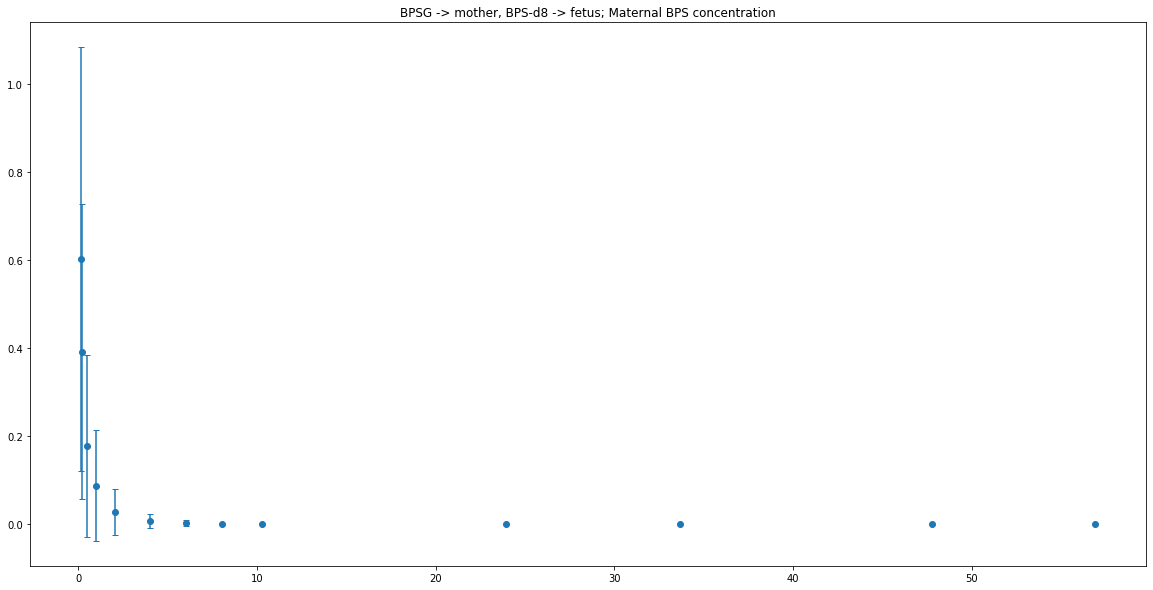

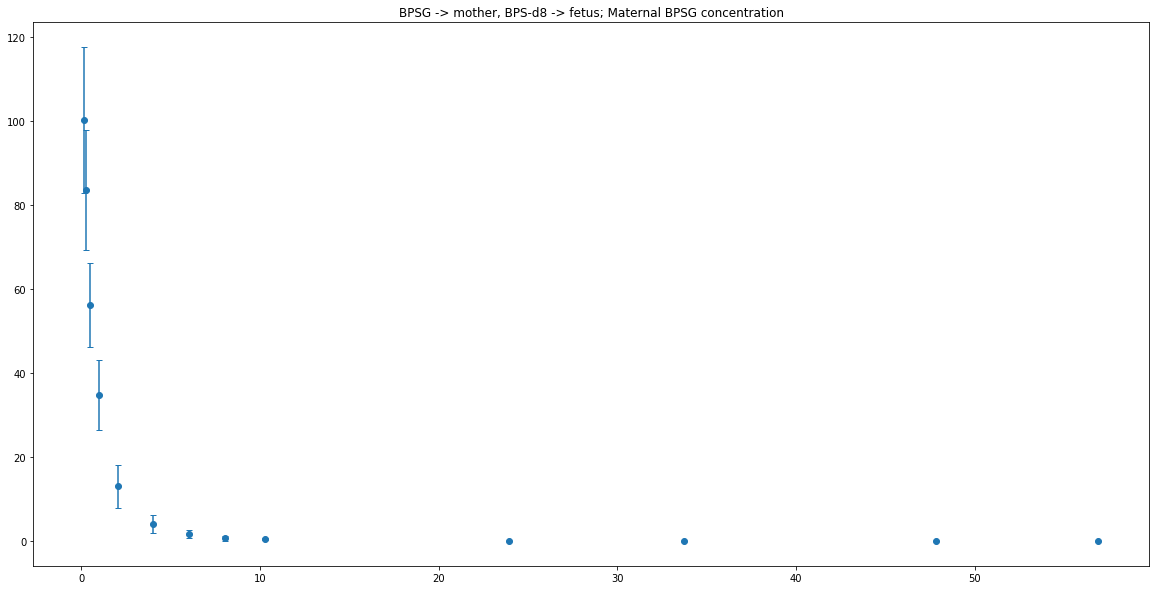

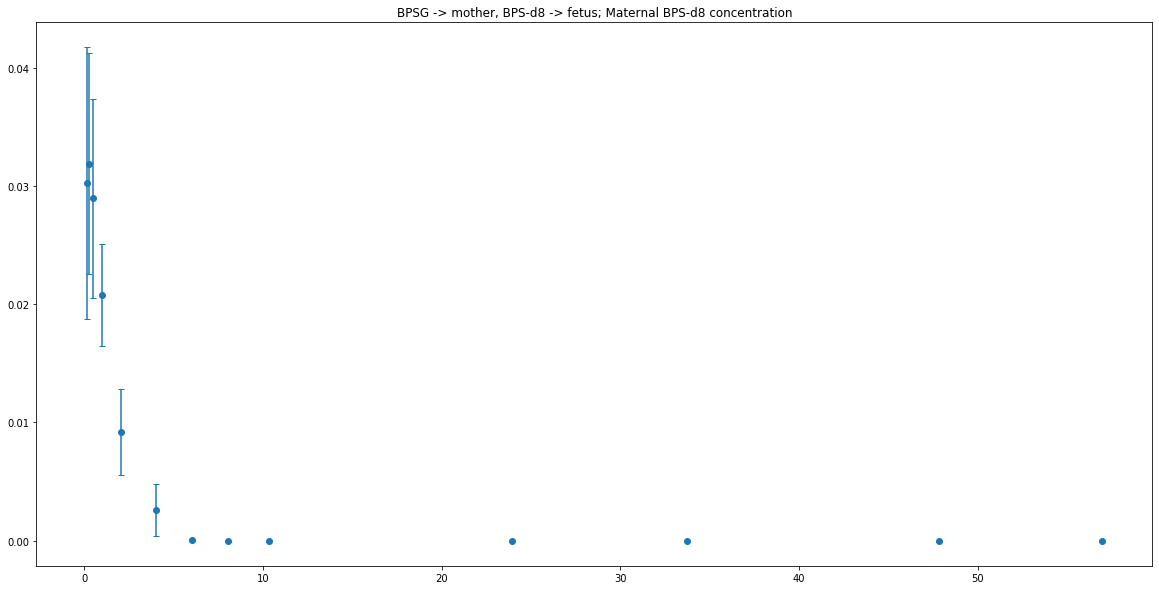

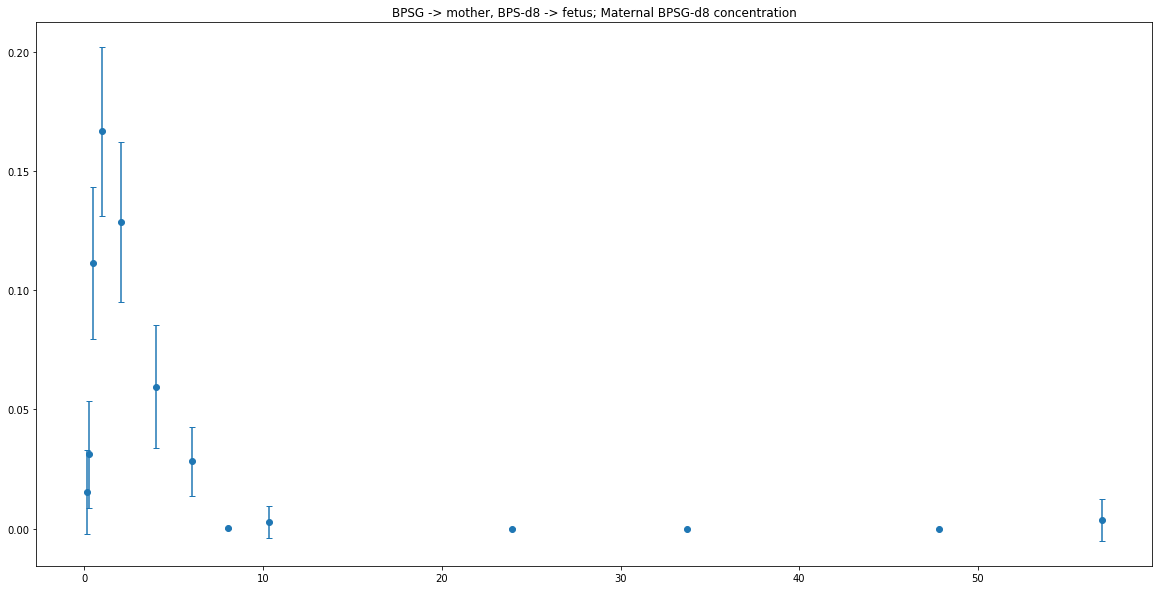



--------------------
BPSG -> mother, BPS-d8 -> fetus; Fetal


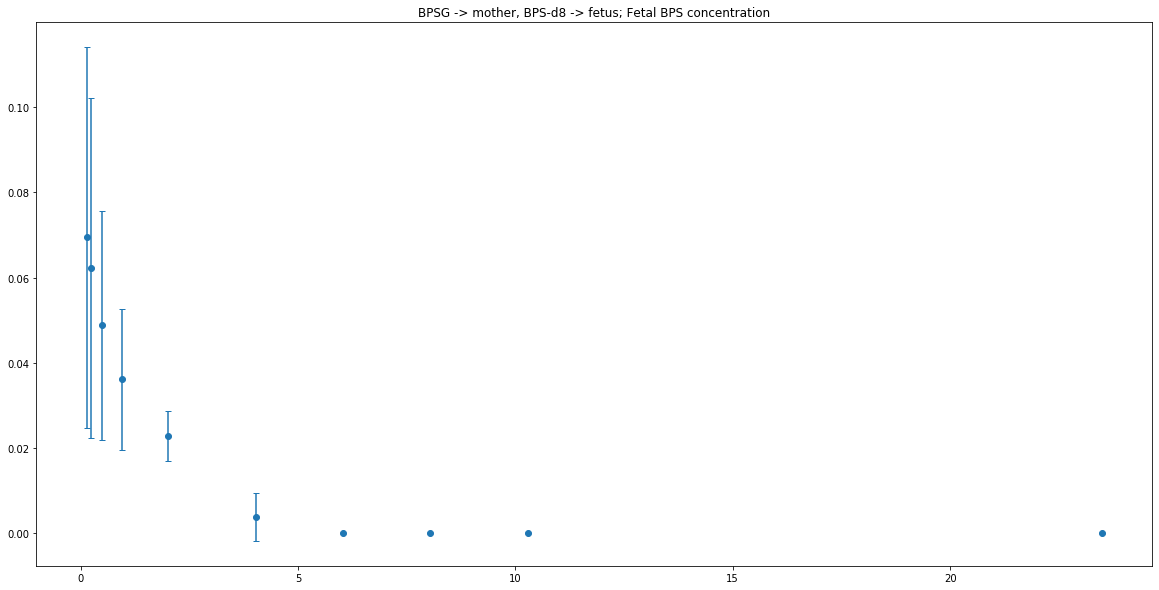

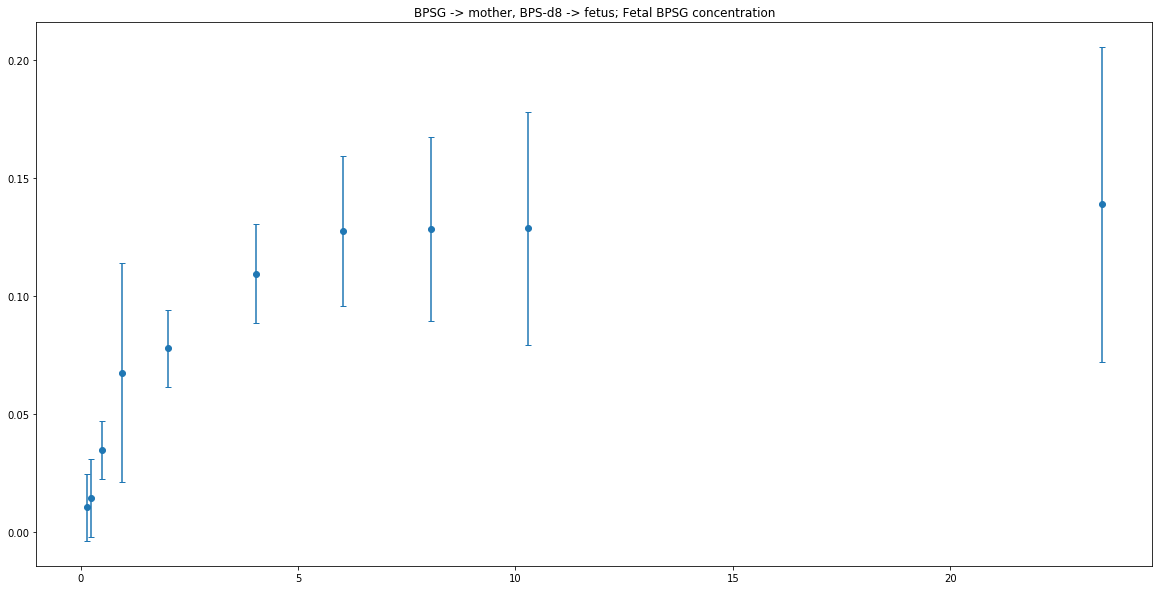

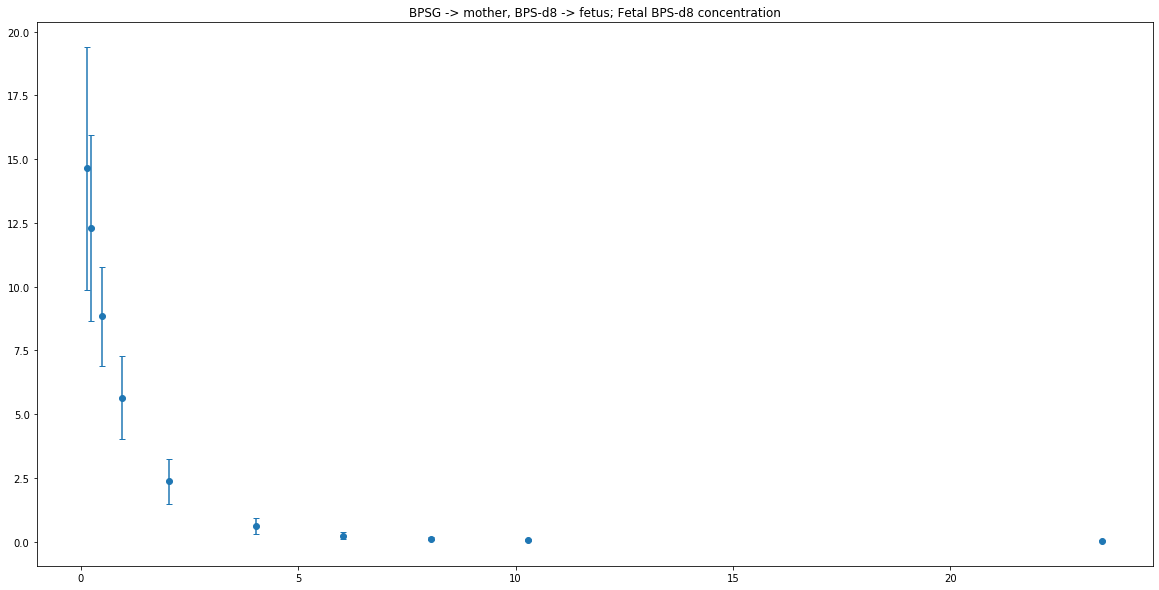

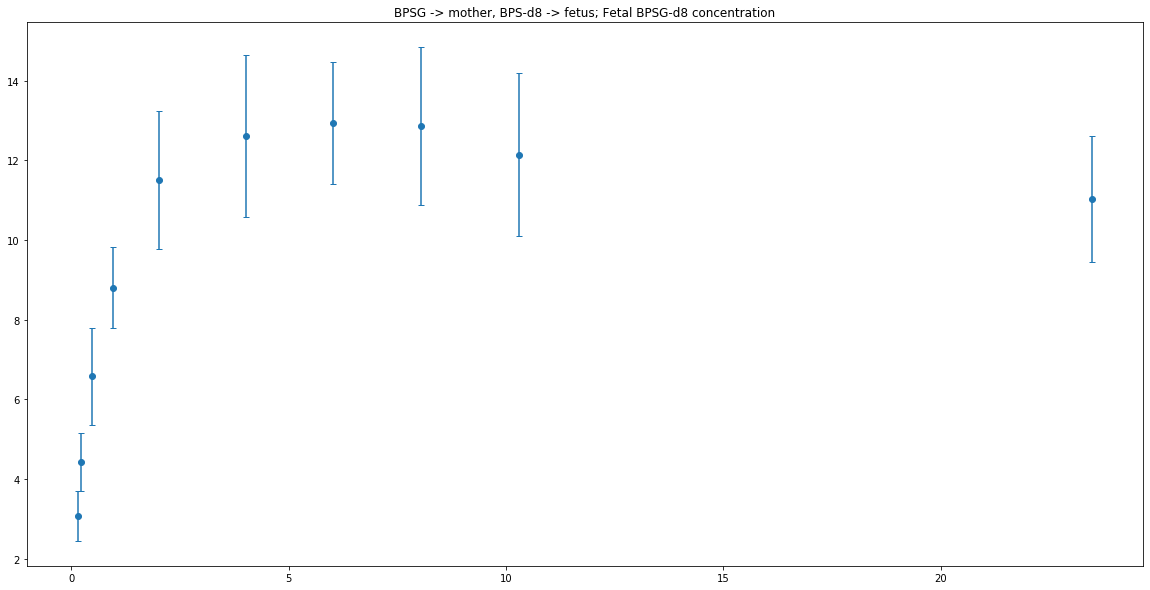



--------------------
BPS -> mother, BPSG-d8 -> fetus; Maternal


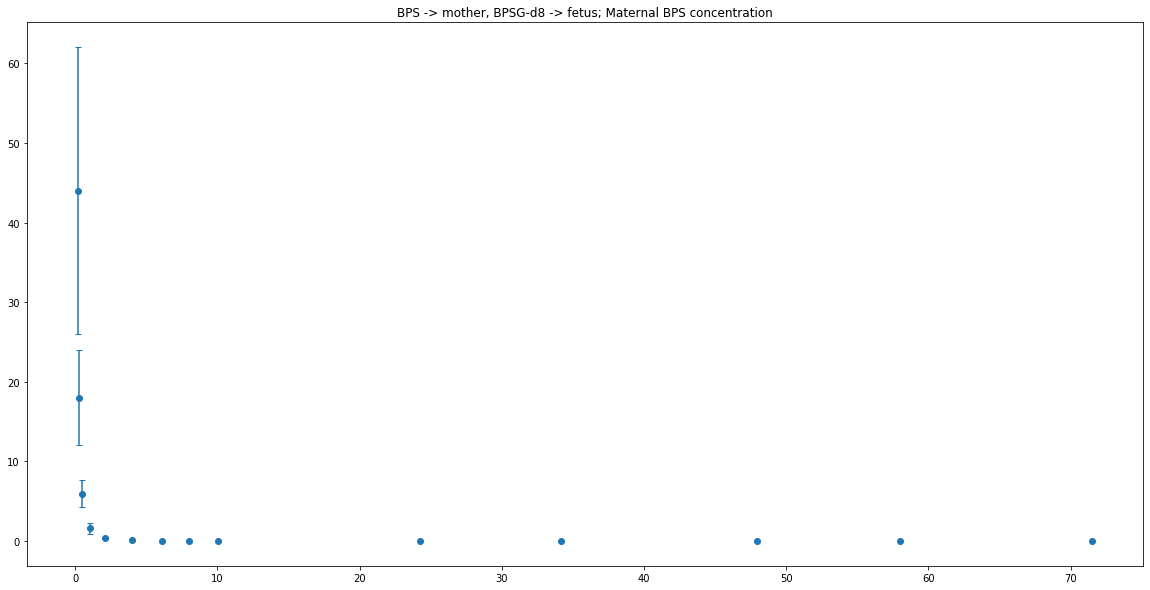

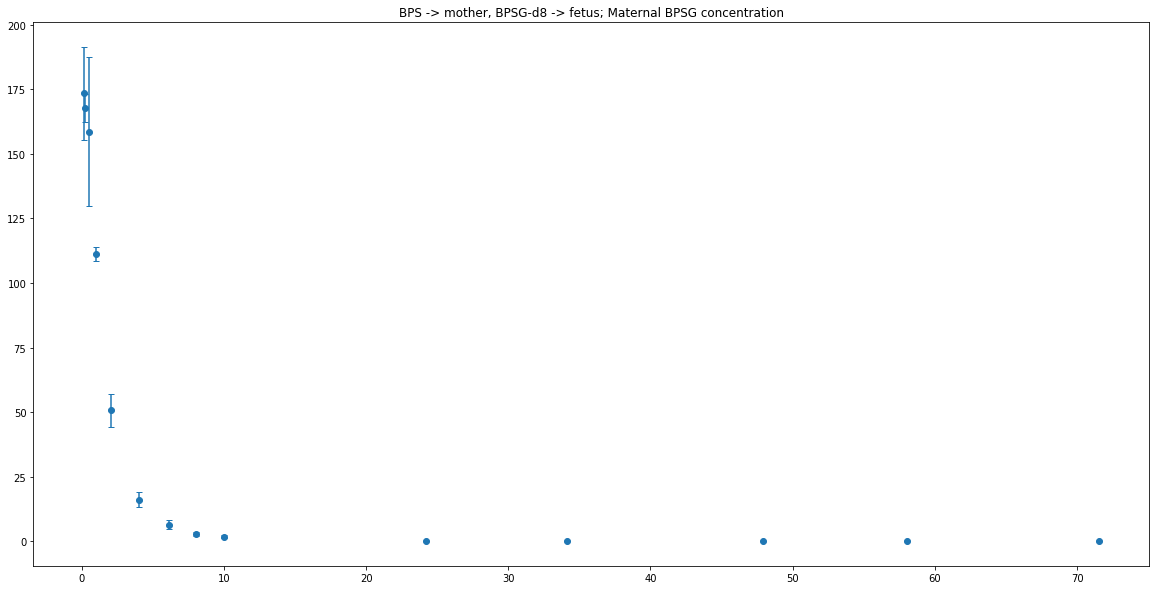

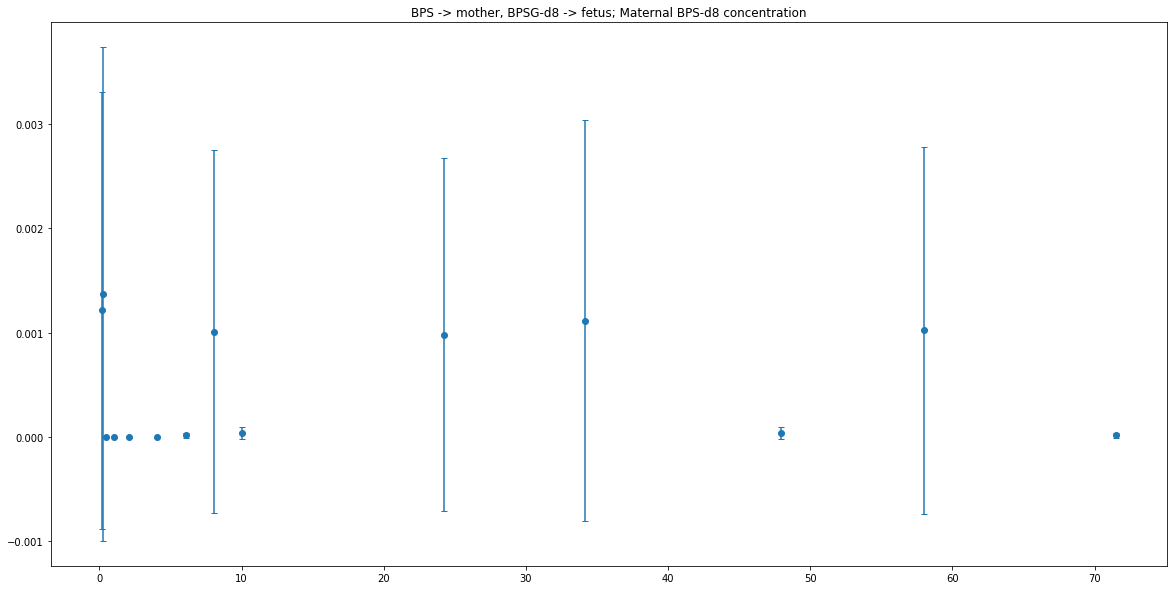

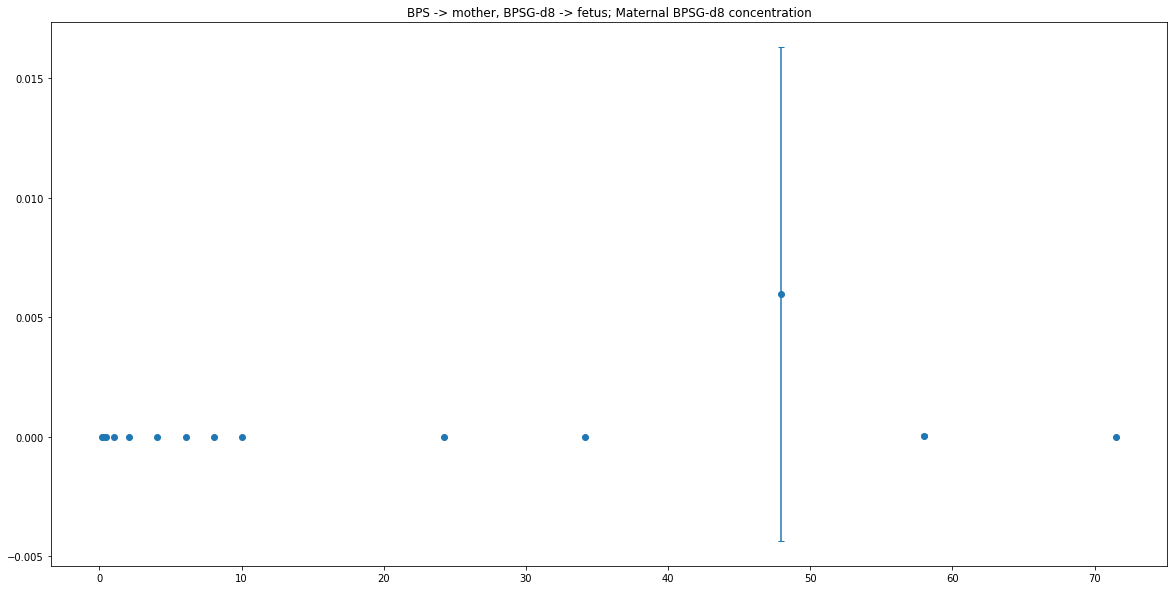



--------------------
BPS -> mother, BPSG-d8 -> fetus; Fetal


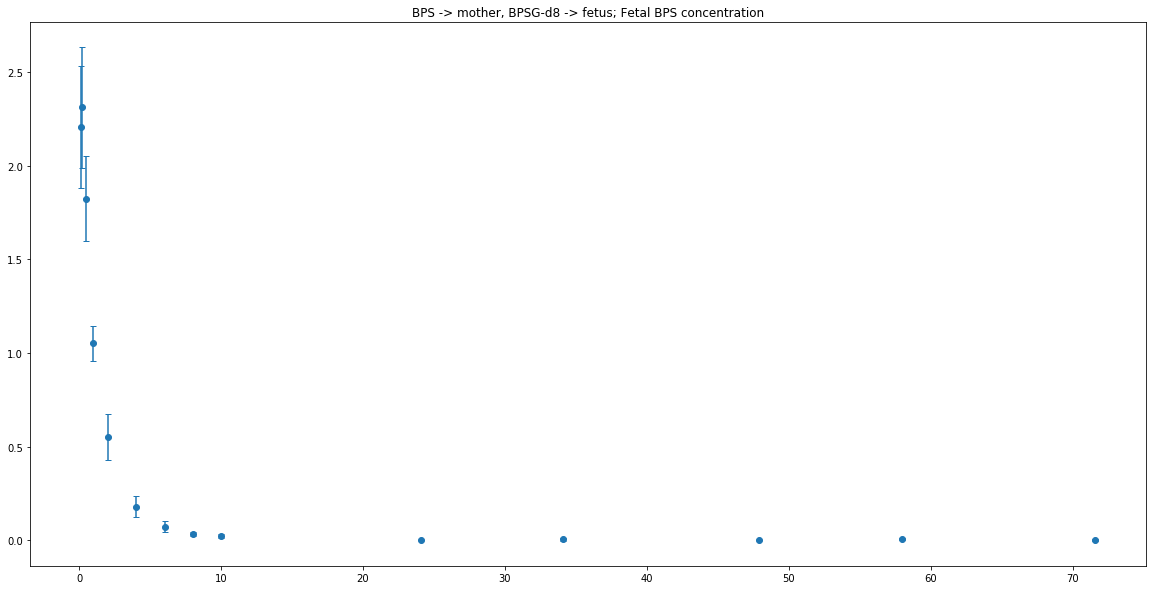

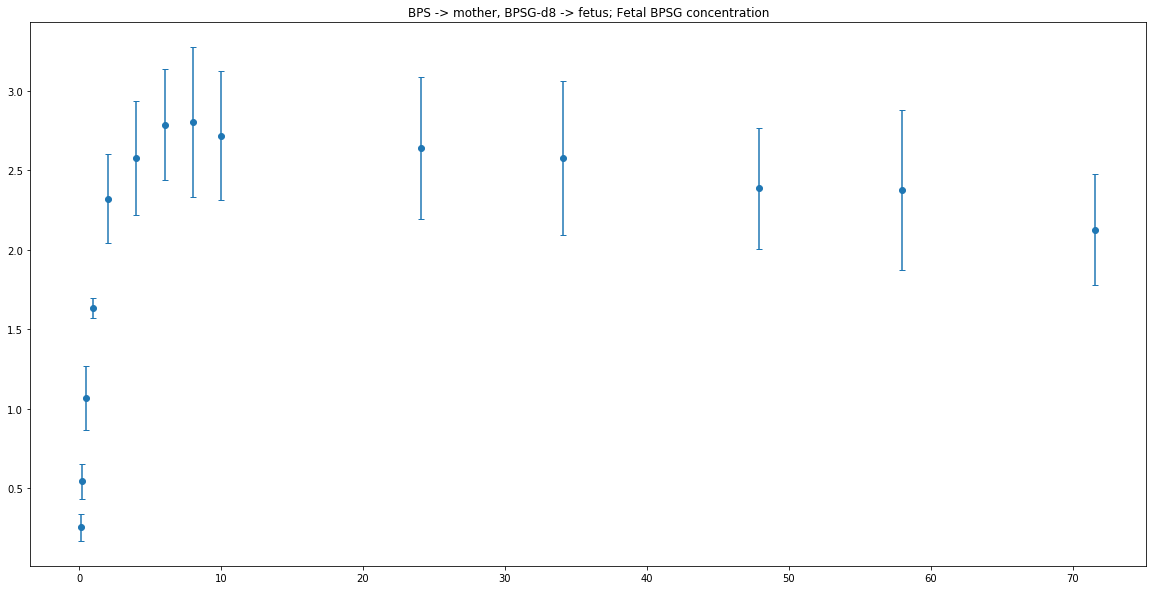

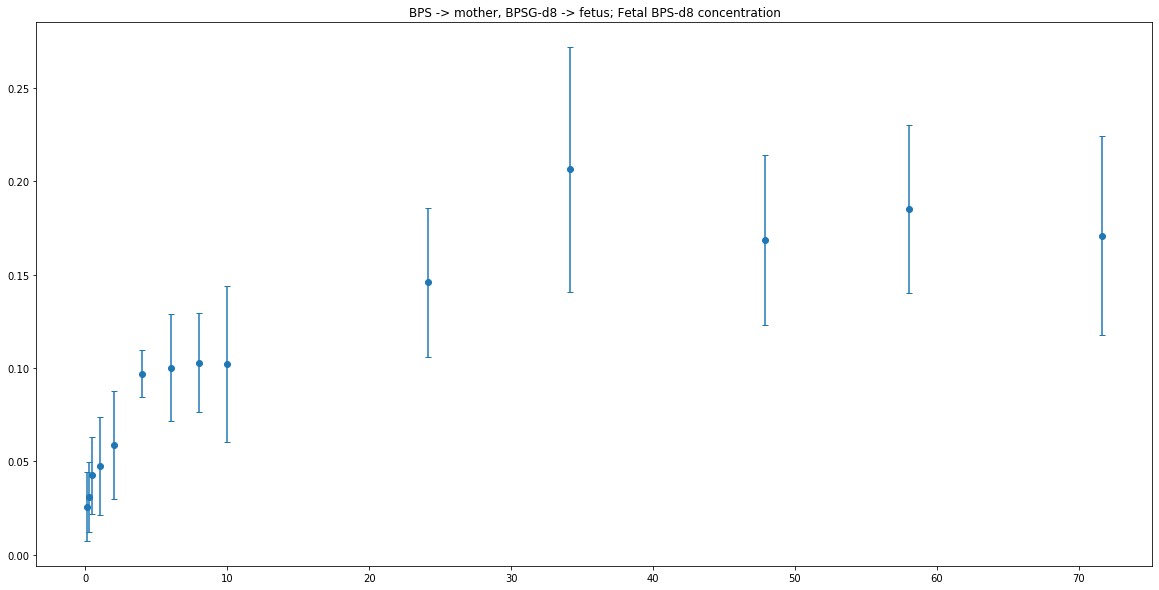

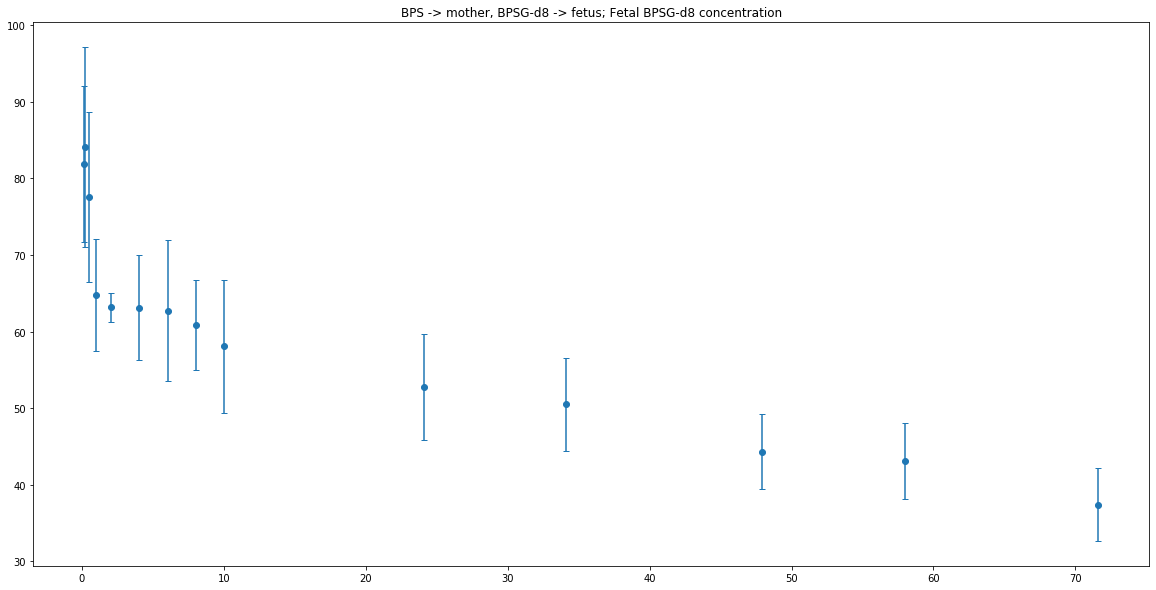

In [48]:
experiments = [experiment1_mother, experiment1_fetus, experiment2_mother, experiment2_fetus]
names = [
    'BPSG -> mother, BPS-d8 -> fetus; Maternal',
    'BPSG -> mother, BPS-d8 -> fetus; Fetal',
    'BPS -> mother, BPSG-d8 -> fetus; Maternal',
    'BPS -> mother, BPSG-d8 -> fetus; Fetal'
]
for experiment, name in zip(experiments, names):
    print('\n\n' + '-'*20 + '\n%s' % name)
    for endpoint in ['BPS', 'BPSG', 'BPS-d8', 'BPSG-d8']:
        plt.figure(figsize=(20,10))
        plt.errorbar(x=experiment['time'][:], y=experiment[endpoint][:], yerr=experiment[endpoint + '_Sd'][:], fmt='o', capsize=3)
        plt.title('%s %s concentration' % (name, endpoint))
        #plt.yscale('log')
        plt.show()